# Gaussian Process Regression

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import nc_to_pd, prepare_simulated

from sklearn.preprocessing import StandardScaler
from gp_functions import fit_predictive_GP, optimize_GP_hyperparams, loglike, squared_exponential_kernel

In [2]:
if sys.platform == 'win32':
    save_folder = "D:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/gaussian_solar_project/data/"
else:
    save_folder = "/home/local/DAC/ahn/Documents/dcwis.solar/dcwis/solar/reports/dtu/"

In [3]:
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])

In [4]:
meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)

neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)

templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)

In [5]:
# prepare our simulated dataframes
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)

In [6]:
# Let us start considering the Meuro dataset

In [7]:
x = meuro_irradiance
y = meuro_sim

In [8]:
# We start by standardizing the data, note we save the standardizers in case we want to add back the mean
x_scaler = StandardScaler().fit(x)
y_scaler = StandardScaler().fit(y)


x = x_scaler.transform(x)
y = y_scaler.transform(y)

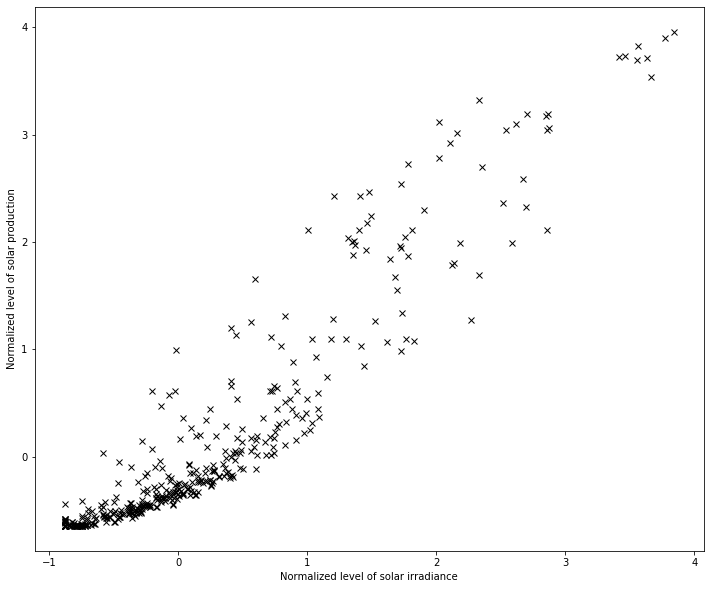

In [9]:
# and plot it
plt.figure(figsize=(12,10))
plt.plot(x, y, 'rx', color='black')
plt.ylabel('Normalized level of solar production')
plt.xlabel('Normalized level of solar irradiance')
plt.show()

In [10]:
# we shall also define the test set, that is the range of XTest points we want to 
# use to compute the mean and the variance
Xtest = np.linspace(-1, 4, 1000).reshape(-1,1)

In [11]:
# We define some initial hyperparameters for our GP
lengthscale, kernel_var, noise_var = 1, 1, 1

In [12]:
# We fit the GP
mu, covariance = fit_predictive_GP(x, y, Xtest, lengthscale, kernel_var, noise_var)
std = np.sqrt(np.diag(covariance))

log_like_initial = loglike(x, y, squared_exponential_kernel, lengthscale, kernel_var, noise_var)

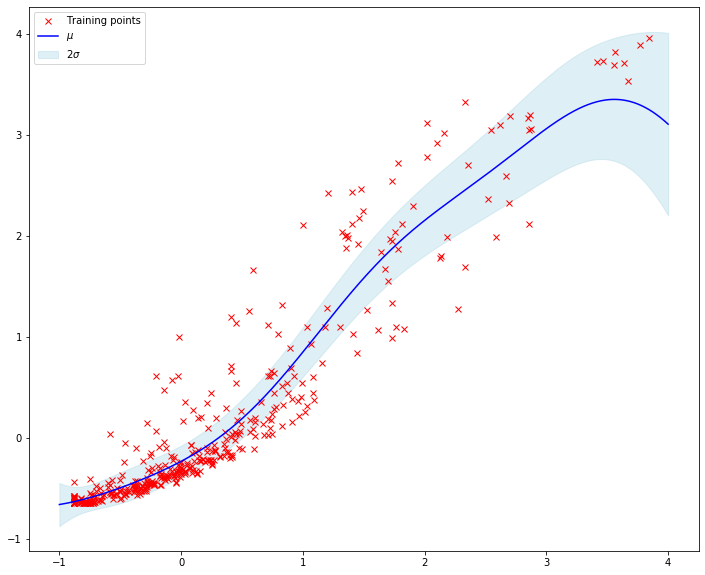

The log likelihood for this fit is 521.6930


In [13]:
# We plot the initial GP
plt.figure(figsize=(12,10))
plt.plot(x, y, 'rx', label='Training points')
plt.gca().fill_between(Xtest.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.4, label=r"$2\sigma$")
plt.plot(Xtest, mu, 'blue', label=r"$\mu$")
plt.legend()
plt.show() 

print('The log likelihood for this fit is %.4f' % -log_like_initial)

In [14]:
# Now we optimize the GP

In [21]:
## we have to define the mena and variance of the log-normal distribution for the lengthscale prior
prior_mean = -1.5
prior_std = 0.6

lengthscale, kernel_var, noise_var = optimize_GP_hyperparams(x, y, 500, 5e-3, prior_mean, prior_std)
print('Optimized parameters:', lengthscale, kernel_var, noise_var)

Optimized parameters: 0.9458286762237549 2.1181082725524902 0.05000000074505806


In [22]:
# We fit the optimized GP
mu, covariance = fit_predictive_GP(x, y, Xtest, lengthscale, kernel_var, noise_var)
std = np.sqrt(np.diag(covariance))

log_like_optim = loglike(x, y, squared_exponential_kernel, lengthscale, kernel_var, noise_var)

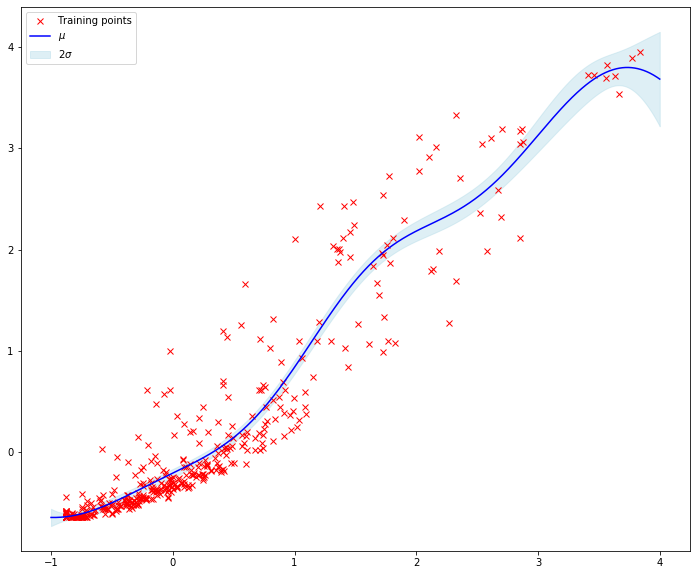

The log likelihood for this fit is 147.2437


In [23]:
# We plot the initial GP
plt.figure(figsize=(12,10))
plt.plot(x, y, 'rx', label='Training points')
plt.gca().fill_between(Xtest.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.4, label=r"$2\sigma$")
plt.plot(Xtest, mu, 'blue', label=r"$\mu$")
plt.legend()
plt.show() 

print('The log likelihood for this fit is %.4f' % -log_like_optim)

It is clear that this fit is considerably better given the lower log likelihood (which we seek to minimize)

In [25]:
# Make predictions on another power plant

x_test = neuhardenberg_irradiance.values.reshape(-1, 1)
y_test = neuhardenberg_sim.values.reshape(-1, 1)

x_test_scaler = StandardScaler().fit(x_test)
y_test_scaler = StandardScaler().fit(y_test)

x_test = x_test_scaler.transform(x_test)
y_test = y_test_scaler.transform(y_test)

In [26]:
# We predict out of sample using the optimized GP
mu, covariance = fit_predictive_GP(x, y, x_test, lengthscale, kernel_var, noise_var)
std = np.sqrt(np.diag(covariance))

In [27]:
mu

array([[-0.63309547],
       [-0.60961762],
       [-0.28148177],
       [ 0.62322541],
       [ 0.11090291],
       [ 0.24270256],
       [ 1.25501877],
       [ 0.12726489],
       [-0.54384128],
       [-0.63309547],
       [-0.63309547],
       [-0.63309547],
       [-0.63079693],
       [-0.54941242],
       [-0.41837731],
       [-0.40442225],
       [-0.29891816],
       [-0.37631316],
       [-0.36220932],
       [-0.56281752],
       [-0.63309547],
       [-0.63309547],
       [-0.63309547],
       [-0.61488358],
       [-0.25720111],
       [ 0.14983797],
       [ 0.35700532],
       [ 0.47021332],
       [ 0.31955015],
       [-0.17098876],
       [-0.54941242],
       [-0.63309547],
       [-0.63309547],
       [-0.63309547],
       [-0.60961762],
       [-0.29193415],
       [-0.08111173],
       [-0.15004911],
       [ 0.24937589],
       [ 0.53126374],
       [-0.05406745],
       [-0.51744295],
       [-0.63309547],
       [-0.63309547],
       [-0.63309547],
       [-0